In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')

In [2]:
recession_vs_yield = pd.read_csv('data/preprocessed.csv', index_col = 'Date')
recession_vs_yield = recession_vs_yield.set_index(pd.DatetimeIndex(recession_vs_yield.index))


#Generate the different features
data_mean = recession_vs_yield.resample('Q-JAN', convention='end').agg('mean')
data_mean['USREC'] = data_mean['USREC'].apply(lambda x: 1 if x > 0 else 0)
data_std = recession_vs_yield.resample('Q-JAN', convention='end').agg('std').drop(columns = ['USREC'])
# data_max = recession_vs_yield.resample('Q-JAN', convention='end').agg('max').drop(columns = ['USREC'])
# data_min = recession_vs_yield.resample('Q-JAN', convention='end').agg('min').drop(columns = ['USREC'])
data_spread = recession_vs_yield.resample('Q-JAN', convention='end').agg('max') - recession_vs_yield.resample('Q-JAN', convention='end').agg('min')
data_spread = data_spread.drop(columns = ['USREC']).add_suffix('_split')

#Merge them features
data = pd.merge_asof(data_mean,data_std, left_index = True, right_index = True, suffixes = ('_mean','_std'))
data = pd.merge_asof(data,data_spread, left_index = True, right_index = True)
data = data.iloc[1:-1 , :]

In [3]:
data.corr()['USREC'].sort_values(ascending=False)

USREC                        1.000000
Bad time to buy_mean         0.467881
Relative_std                 0.422957
Relative_split               0.422418
Good time to buy_std         0.405985
Good time to buy_split       0.403911
Bad time to buy_std          0.393744
Bad time to buy_split        0.386813
Value_3mon_std               0.385898
Value_3mon_split             0.381013
spread_std                   0.373216
spread_split                 0.367192
Value_10yr_std               0.272051
Value_10yr_split             0.267095
Value_10yr_mean              0.206963
Value_3mon_mean              0.200820
Uncertain - depends_mean     0.097177
Uncertain - depends_std      0.052980
Uncertain - depends_split    0.052935
spread_mean                 -0.025292
Relative_mean               -0.494692
Good time to buy_mean       -0.510549
Name: USREC, dtype: float64

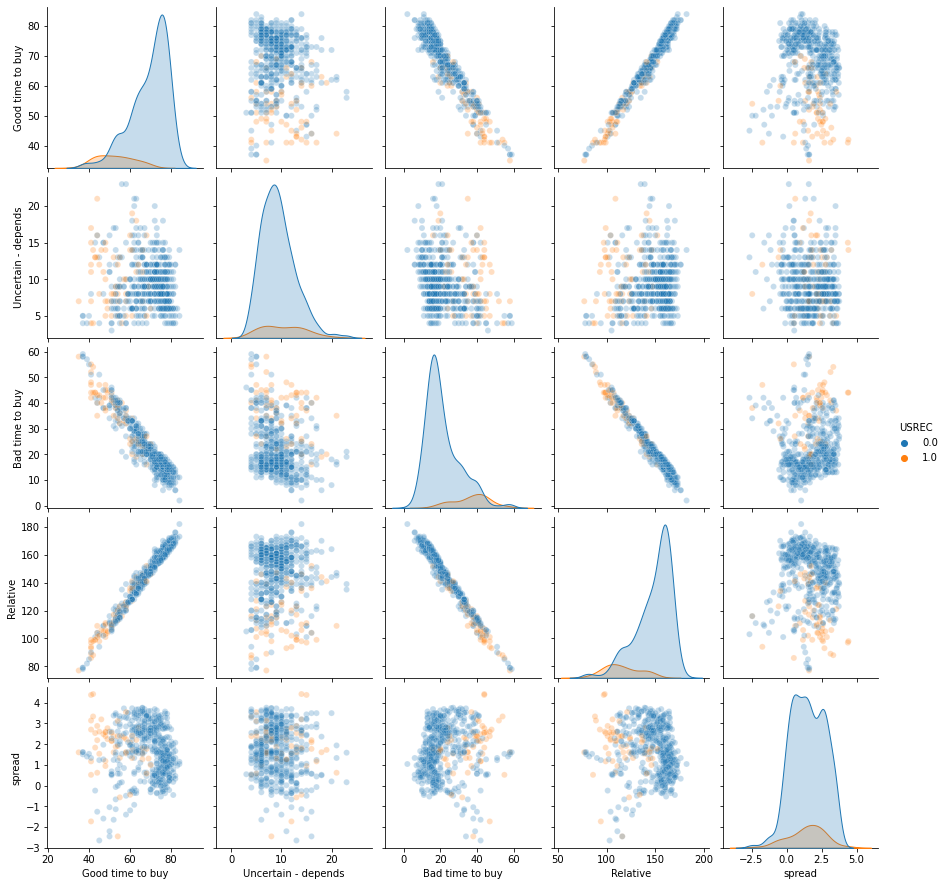

In [47]:
import seaborn as sns
sns.pairplot(recession_vs_yield.drop(columns = ['Value_10yr','Value_3mon']), hue = 'USREC', plot_kws={'alpha': 0.25});
#Hex distribution

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE


sm = SMOTE(random_state=42)
X = data.drop(columns = ['USREC'])
y = data['USREC']
smpl = SimpleImputer(strategy = 'median')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
X_imputed = smpl.fit_transform(X_train)
X_train, y_train = sm.fit_resample(X_imputed, y_train)

In [69]:
steps = [('imputer', SimpleImputer(strategy = 'median')), ('scaler', StandardScaler()), ('rgsr', LogisticRegression())]
pipe = Pipeline(steps)
pipe.fit(X_train,y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('rgsr', LogisticRegression())])

In [109]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


In [110]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_test_pred)

0.6875

In [111]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

conf = confusion_matrix(y_train,y_train_pred, normalize = 'true')
disp = ConfusionMatrixDisplay(conf)
#disp.plot()

Aera under the curve:  0.8884


/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


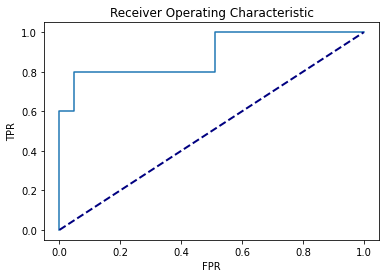

In [112]:
fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:, 1])
fig, ax = plt.subplots()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Receiver Operating Characteristic')
aucscore = auc(fpr,tpr)
print('Area under the curve: ',round(aucscore,4));

In [103]:
y_probas = pipe.predict_proba(X_test)[:,1]
custom_thresh_y_pred_test = [1 if y > 0.8 else 0 for y in y_probas]
# y_probas = pipe.predict_proba(X_train)[:,1]
# custom_thresh_y_pred_train = [1 if y > 0.15 else 0 for y in y_probas]

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


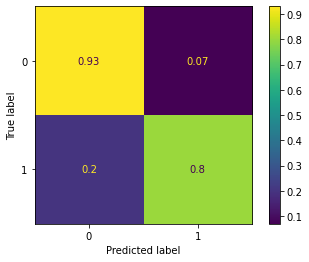

In [104]:
import numpy as np
conf = confusion_matrix(y_test,np.array(custom_thresh_y_pred_test), normalize='true')
disp = ConfusionMatrixDisplay(conf)
disp.plot();

In [105]:
from sklearn.metrics import classification_report
report = classification_report(y_test,custom_thresh_y_pred_test, output_dict = True)

In [106]:
report['0']

{'precision': 0.975609756097561,
 'recall': 0.9302325581395349,
 'f1-score': 0.9523809523809524,
 'support': 43}

In [107]:
report['1']

{'precision': 0.5714285714285714,
 'recall': 0.8,
 'f1-score': 0.6666666666666666,
 'support': 5}